<a href="https://colab.research.google.com/github/jtrinquier/SoftAlign/blob/main/Colab/COLAB_SoftAlign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  SoftAlign: Structural Alignment via Soft Matching

Welcome to **SoftAlign**, a  Colab notebook for performing **pairwise protein structural alignments** using a soft, differentiable end to end model.

---

### ⚙️ How to Use

1. **Select your proteins**  
   Provide the **two protein names** using their:
   - UniProt IDs (e.g., `Q5VSL9`, `A0A7L4L2T3`) → downloads **AlphaFold models**
   - PDB codes (e.g., `1P9G`, `1HEV`) → downloads **experimental structures**
   - Or upload your own **custom `.pdb` files**

2. **Run all cells**  
   After setting the inputs, run the notebook from top to bottom to:
   - Load the proteins
   - Extract MPNN inputs
   - Run the SoftAlign model
   - Visualize and compare alignment results

3. **Tune alignment softness**  
   You can adjust the **temperature parameter** (`t`) to control alignment entropy:
   - Low `t` → sharp alignment (close to hard match)
   - High `t` → softer alignment (more spread across options)

4. **Try softmax visualization**  
   Activate the `soft_max` toggle to view what the pseudo-alignment model looks like.  
   *Note: This mode isn't optimal for alignment, but helps visualize how the softmax model reacts to structural similarity/ lack of structural similarity.*

---

### 🧠 What this notebook does:
- **Aligns two protein structures** using SoftAlign
- Compares to classical TM-align alignment
- Computes **TM-score** and **LDDT** scores
- Visualizes both **soft alignment matrices** and **TM-align alignments**
- Visualize similarity matrix

---

> This notebook is focused on **pairwise alignment only**.  
> For large-scale or batched alignments, please refer to the full SoftAlign repository.

In [1]:
# @title Import libraries
import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
! git clone https://github.com/jtrinquier/SoftAlign.git
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import pandas as pd
import haiku as hk
import os
import re
import sys
softalign_path = os.path.join(os.getcwd(), 'SoftAlign')

# Add SoftAlign directory to sys.path if it's not already there
if softalign_path not in sys.path:
    sys.path.append(softalign_path)
softalign_code_path = os.path.join(softalign_path, 'softalign/colab')
if softalign_code_path not in sys.path:
    sys.path.append(softalign_code_path)
import Input_MPNN as input_
import END_TO_END_MODELS as ete
import Score_align as score_
import Score_align as lddt

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-8n3mvyt0
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-8n3mvyt0
  Resolved https://github.com/deepmind/dm-haiku to commit 92eea68c85313fe96715220fc986afd121176a8e
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.17.dev0-py3-none-any.whl size=374528 sha256=8c76a17243057f0e764fe16b039a0a48823162d80f80130779c00ca5b855b185
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_bkxyrr/wheels/9e/61/4f/80a3533070997bbf330ff52c178cc780d5e60ad222899e2924
Successfully built dm-haiku
Cloning into 'SoftAlign'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 139 (delta 42), reused 18 (delta 18), pack-reused 81 (from 1)
Receiving objects: 100% (139/139), 3.48 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (69/69), done.


#tmalign

In [2]:


!git clone https://github.com/kad-ecoli/TMalign.git
%cd TMalign
!g++ -O3 -ffast-math -lm -o TMalign TMalign.cpp
! g++ -O3 -ffast-math -lm -o TMscore TMscore.cpp
%cd ..


Cloning into 'TMalign'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 813 (delta 48), reused 50 (delta 26), pack-reused 737 (from 1)
Receiving objects: 100% (813/813), 1.05 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (574/574), done.
/content/TMalign
/content


In [3]:
import os
def tmscore(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign/TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

In [4]:
def tmalign(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign/TMalign 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {"tms":[]}
  aln = []
  aln_mode = False
  for line in output:
    line = line.rstrip()
    if line.startswith("TM-score"): o["tms"].append(parse_float(line))
    if line.startswith('(":"'): aln_mode = True
    elif aln_mode == True and len(aln) < 3: aln.append(line)
    else: aln_mode = False

  o["aln"] = aln
  aln = []
  a,b = 0,0
  for n in range(len(o["aln"][0])):
    x = o["aln"][0][n]
    y = o["aln"][2][n]
    if x != "-":
      if y != "-": aln.append(b)
      else: aln.append(-1)
    if x != "-": a += 1
    if y != "-": b += 1

  o["aln"] = np.asarray(aln)
  return o

# Load PDB and Model


🧬 PDB Downloader Instructions

This cell lets you download or load two PDB structures using three modes:

    af (AlphaFold)
    Downloads from the AlphaFold DB using UniProt IDs (e.g., Q5VSL9).

    pdb (RCSB PDB)
    Downloads from the RCSB Protein Data Bank using standard PDB IDs (e.g., 1P9G).

    custom
    Lets you use your own files named pdb1.pdb and pdb2.pdb.
    Upload them using the file panel on the left in Colab.

📌 Usage Notes:

    Select the mode from the dropdown (af, pdb, or custom).

    Enter the two structure IDs.

    Run the cell to download or load the structures.

    Files will be saved as pdb1.pdb and pdb2.pdb in the workspace.

In [5]:
# @title Pdb files
import os

# === Form Inputs ===
pdb_source = "af"  #@param ["af", "pdb", "custom"] {type:"string"}
pdb1 = "Q5VSL9"  #@param {type:"string"}
pdb2 = "A0A7L4L2T3"  #@param {type:"string"}

# === Logic ===
if pdb_source == "af":
    os.system(f"wget -qO {pdb1}.pdb https://alphafold.ebi.ac.uk/files/AF-{pdb1}-F1-model_v6.pdb")
    os.system(f"wget -qO {pdb2}.pdb https://alphafold.ebi.ac.uk/files/AF-{pdb2}-F1-model_v6.pdb")
    print("✅ Downloaded from AlphaFold")

elif pdb_source == "pdb":
    os.system(f"wget -qO {pdb1}.pdb https://files.rcsb.org/view/{pdb1}.pdb")
    os.system(f"wget -qO {pdb2}.pdb https://files.rcsb.org/view/{pdb2}.pdb")
    print("✅ Downloaded from RCSB PDB")

elif pdb_source == "custom":
    print("📂 Using custom uploaded files: make sure 'pdb1.pdb' and 'pdb2.pdb' are uploaded via the file sidebar in Colab.")
else:
    print("❌ Invalid source. Please choose from 'af', 'pdb', or 'custom'")


✅ Downloaded from AlphaFold


In [6]:
X2,mask2,chain2,res2 = input_.get_inputs_mpnn(pdb2+".pdb",chain = 'A')
X1,mask1,chain1,res1 = input_.get_inputs_mpnn(pdb1+".pdb",chain = 'A')

### Model Loading Instructions

This cell loads the end-to-end SoftAlign model with the option to toggle **softmax** activation.

- If `soft_max` is **False**, it loads the standard model weights:
  - `./SoftAlign/models/CONT_SW_05_T_3_1`

- If `soft_max` is **True**, it loads the softmax-activated model weights:
  - `./SoftAlign/models/CONT_SFT_06_T_3_1`

**Note:**  
The **categorical model** variant is not yet available but will be added soon.

Set the `soft_max` toggle above to switch between these two model versions.


In [7]:
# @title Model
soft_max = False  #@param {type:"boolean"}

# Fixed parameters - do NOT modify
num_layers = 3
num_neighbors = 64
encoding_dim = 64
bs = 15
categorical = False  # fixed to False for now
nb_clusters = 100
affine = True

def model_end_to_end(x1, x2, lens, t):


    if categorical:
        a = ete.END_TO_END_SEQ_KMEANS(
            encoding_dim, encoding_dim, encoding_dim, num_layers,
            num_neighbors, nb_clusters=nb_clusters, affine=affine,
            soft_max=soft_max, dropout=0., augment_eps=0.0)
    else:
        a = ete.END_TO_END(
            encoding_dim, encoding_dim, encoding_dim, num_layers,
            num_neighbors, affine=affine, soft_max=soft_max,
            dropout=0., augment_eps=0.0)
    return a(x1, x2, lens, t)

import jax
import pickle

key = jax.random.PRNGKey(0)

# Choose model path based on soft_max toggle
params_path = "./SoftAlign/models/CONT_SW_05_T_3_1"
if soft_max:
    params_path = "./SoftAlign/models/CONT_SFT_06_T_3_1"

params = pickle.load(open(params_path, "rb"))
print(f"✅ Loaded model params from {params_path}")


MODEL_ETE = hk.transform(model_end_to_end)
x1 = X1,mask1,chain1,res1
x2 = X2,mask2,chain2,res2
lens = jnp.array([X1.shape[1],X2.shape[1]])[None,:]


✅ Loaded model params from ./SoftAlign/models/CONT_SW_05_T_3_1


/tmp/ipython-input-2091728206.py:38: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  params = pickle.load(open(params_path, "rb"))


## Temperature parameter (`t`) in soft alignment model

- The temperature controls the "softness" of the alignment matrix.
- **Higher `t` values** (e.g., 1.) produce *softer* alignments, meaning the model spreads alignment probability more evenly, allowing more uncertainty.
- **Lower `t` values** (e.g., 1e-5 or 1e-6) produce *harder* alignments, focusing probability on fewer matches with more confidence.
- Adjust `temperature` above to control this behavior and explore different alignment smoothness.

Try different values and see how it affects the resulting alignment!

In [8]:
# Temperature parameter controls softness of alignments
# Higher temperature = softer alignments (more uncertainty)
# Lower temperature = harder alignments (more confident)
# @title Compute alignment from SoftALign

temperature = 1e-4  #@param {type:"number"}

# Run model inference with chosen temperature
soft_aln, sim_matrix, score = MODEL_ETE.apply(params, key, x1, x2, lens, temperature)

print(f"Temperature set to {temperature:.1e}")


Temperature set to 1.0e-04


## Visualization of Soft Alignment Matrix

- The main plot shows the **soft alignment matrix** produced by our model, representing the probabilistic matchings between positions of the two sequences `X1` and `X2`.
- The **inset** displays a one-hot encoded **hard alignment** matrix derived from TM-align, a structural alignment method, for direct comparison.
- You can see how the model’s soft alignments compare to the discrete TM-align results.
- The **TM-score** printed indicates the quality of the alignment in terms of structural similarity.
- This soft alignment matrix (variable soft_aln) is the key output from the model and can be further used for downstream analysis or visualization.


In [9]:
# @title Print some scores

#print(tmalign(X1[0, :, 1], X2[0, :, 1]))
aln_tmalign = tmalign(X1[0, :, 1], X2[0, :, 1])['aln']
one_hot_data = jax.nn.one_hot(aln_tmalign, X2.shape[1])
one_hot_data = one_hot_data[None, :, :]  # Add batch dimension

# Create dummy masks
mask_1 = jnp.ones((1, X1.shape[1], X1.shape[1]))
mask_2 = jnp.ones((1, X2.shape[1], X2.shape[1]))

# === TM-scores ===
tm_soft = tmscore(X1[0, :, 1], soft_aln[0] @ X2[0, :, 1])
tm_hard = tmscore(X1[0, :, 1], one_hot_data[0] @ X2[0, :, 1])
print(tm_soft)
# === LDDT scores ===
lddt_soft_1 = lddt.get_LDDTloss(X1[:, :, 1], X2[:, :, 1], soft_aln, mask_1, mask_2, 1e-4)
lddt_soft_2 = lddt.get_LDDTloss(X2[:, :, 1], X1[:, :, 1], soft_aln.transpose(0, 2, 1), mask_2, mask_1, 1e-4)

lddt_hard_1 = lddt.get_LDDTloss(X1[:, :, 1], X2[:, :, 1], one_hot_data, mask_1, mask_2, 1e-4)
lddt_hard_2 = lddt.get_LDDTloss(X2[:, :, 1], X1[:, :, 1], one_hot_data.transpose(0, 2, 1), mask_2, mask_1, 1e-4)

# === Print Summary ===
print(f"📎 Comparing alignments between **{pdb1}** and **{pdb2}**\n")
print(f"🧠 SoftAlign model:")
print(f"  • TM-score:       {tm_soft['tms']:.4f}")
print(f"  • LDDT {pdb1}→{pdb2}: {lddt_soft_1[0]:.4f}")
print(f"  • LDDT {pdb2}→{pdb1}: {lddt_soft_2[0]:.4f}")

print(f"\n📐 TM-align reference:")
print(f"  • TM-score:       {tm_hard['tms']:.4f}")
print(f"  • LDDT {pdb1}→{pdb2}: {lddt_hard_1[0]:.4f}")
print(f"  • LDDT {pdb2}→{pdb1}: {lddt_hard_2[0]:.4f}")

{'rms': 23.576, 'tms': 0.6548, 'gdt': 0.5803}
📎 Comparing alignments between **Q5VSL9** and **A0A7L4L2T3**

🧠 SoftAlign model:
  • TM-score:       0.6548
  • LDDT Q5VSL9→A0A7L4L2T3: 0.6294
  • LDDT A0A7L4L2T3→Q5VSL9: 0.9294

📐 TM-align reference:
  • TM-score:       0.6676
  • LDDT Q5VSL9→A0A7L4L2T3: 0.6386
  • LDDT A0A7L4L2T3→Q5VSL9: 0.9430


/tmp/ipython-input-310172284.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


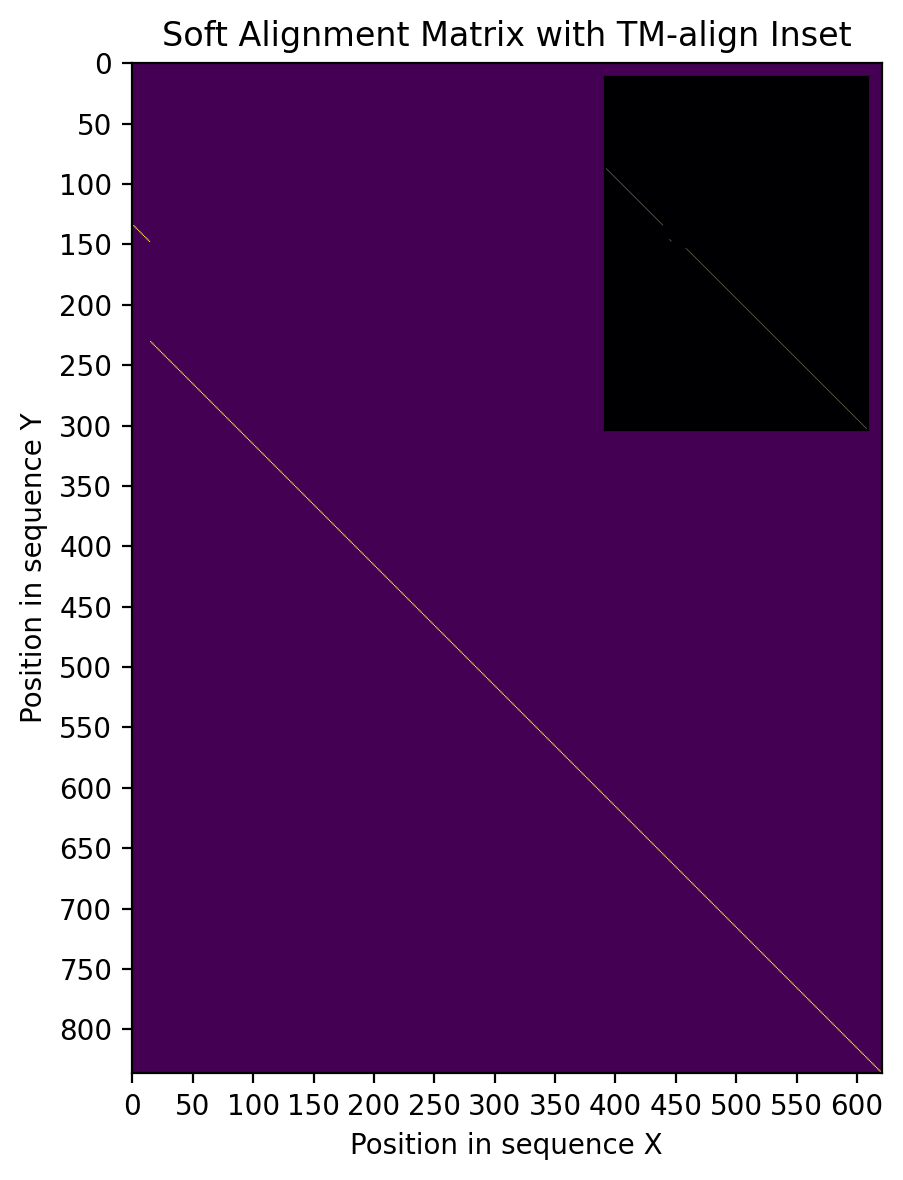

In [10]:
# @title Visualize alignment

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import jax.numpy as jnp



plt.figure(dpi=200, figsize=(6, 6))
ax = plt.gca()


# Plot the soft alignment matrix obtained from the model
plt.imshow(soft_aln[0], aspect='auto')


plt.xlabel("Position in sequence X")
plt.ylabel("Position in sequence Y")
plt.title("Soft Alignment Matrix with TM-align Inset")

# Adjust ticks
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xticks(range(int(xlim[0]), int(xlim[1])+1, 50))  # every 50 units on X
ax.set_yticks(range(int(ylim[1]), int(ylim[0])+1, 50))  # every 50 units on Y
ax.set_aspect('equal', adjustable='box')

# Inset: Show TM-align one-hot encoded alignment for comparison
ax_inset = inset_axes(ax, width="35%", height="35%", loc='upper right')
ax_inset.imshow(one_hot_data[0], cmap='magma', aspect='auto')
ax_inset.set_xticks([])
ax_inset.set_yticks([])

plt.tight_layout()
plt.show()



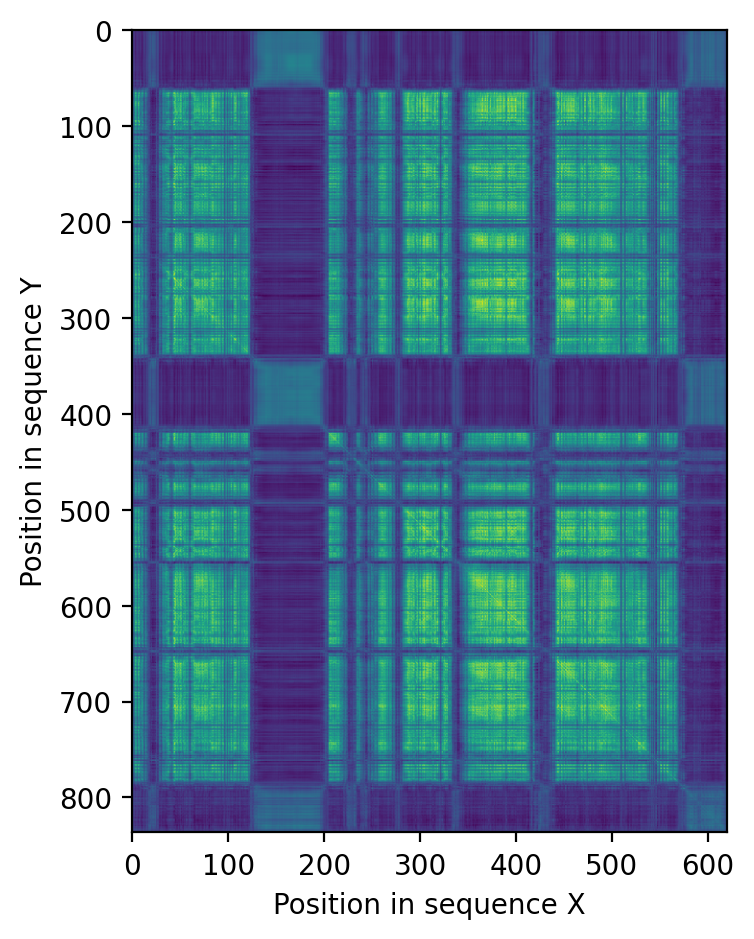

In [11]:
# @title Visualize similarity Matrix

plt.figure(dpi = 200)
plt.imshow(sim_matrix[0], aspect='auto')
#plt.colorbar()
plt.xlabel("Position in sequence X")
plt.ylabel("Position in sequence Y")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax = plt.gca()



# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()